# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Import the needed tools

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
import re
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pyspark.sql.functions import *

import random

from pyspark.sql import Row

from sklearn import neighbors

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .config("spark.driver.memory", "15g") \
    .appName("Creating Features") \
    .getOrCreate()

sc = spark.sparkContext

## 1.INTRODUCTION

The current wave of digitization sweeping across industries has led to explosion of data, as information is being tracked using different tools. This, together with the advent of social media has greatly emboldened the inclination and match towards artificial intelligence. This is grounded on the ability to obtain insights from the massive amounts of data obtained sometimes in real times while powering products that rely on such data. Technologies to wrangle such big data are currently being championed by Apache Hadoop and Spark. One single computer is not able to handle such massive datasets, and calls for multiple computers which can be hosted online using computing platforms such as Amazon Web Services (AWS), Microsoft Azure, IBM Watson, and Google Cloud. This brings to the goal of this write up which will apply a big data technology (Spark) to a subset (128 MB)
of a larger dataset of about 12GB.

The dataset here is from Udacity for a pseudo-music streaming service called 'Sparkify' where users have been using either as guests, free, or paid levels. Some of the users, after using the service for a while as paid subscribers end up cancelling their subscription. The goal is therefore to be able to predict the churn of such users which here is defined as when a user is tracked in the 'Cancel Confirmation' page, using the different features measured while the user has been using the platform. The end product of this project would be a model that can be deployed on the sparkify app/platform to predict if a given user stand a chance of cancelling their subscription, and then move swiftly to prevent such case.

The prediction of churn users for the sparkify dataset will be handled using machine learning technques. First of all, the dataset will be explored to obtain quality insights into the behaviour of the users/subscribers. Then features will be engineered that most strongly explain the behaviours. This will be followed by modellng which will involve first defining a baseline model, and working to improve this baseline model. As such, metrics perculier to classification tasks will be used. Such metrics as Fscore and accuracy will be used to measure the perfromance of the different models while working to improve them. 

F1-score in particular was used as the deciding metric. F1 is defined as the harmonic mean of the precision and recall. Remember that precision is a measure of true positives over all positive predictions, while recall is a measure of true positive predictions over all positive labels. Hence F1-score was used to capture how well the model can distinguish between the two classes in its predictions, while quantifying the prediction of positves (defined here as churn or label == 1). This is against accuracy which will not capture how well the prediction was made for users who will cancel their subscription

In [3]:
def load_data(path):
    '''
    Function to load a data into a spark dataframe using path of a json dataset.
    Args:
        path- the path where the data is stored
    Returns:
        A dataframe of the dataset.
    '''
    path = path
    return spark.read.json(path)


df = load_data('mini_sparkify_event_data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
#Size of dataset

df.count()

286500

## 2. BUSINESS AND DATA UNDERSTANDING

 Take a look at the descriptive statistics of the dataframe

In [5]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Find out where userids are null or non existent

In [9]:
df.select("*").where(col("userId").isNull()).count()

0

In [10]:
df.select("*").where(col("sessionId").isNull()).count()

0

In [6]:
#Used this to take a look at all possible user ids and found empty #string users

df.select('userId').groupby('userId').count().show(4) 

+------+-----+
|userId|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
+------+-----+
only showing top 4 rows



In [19]:
df.select("userId").where(col("userId")=='').count()

8346

Check to see if these are just invalid data or has correlation with users being logged in or out.

In [28]:
df.select("userId",'auth').where(col("userId")=='').where(col('auth') == 'Logged In').count()

0

Find out the different categories of the column 'auth'

In [35]:
df.select('auth').groupby('auth').count().collect()

[Row(auth='Logged Out', count=8249),
 Row(auth='Cancelled', count=52),
 Row(auth='Guest', count=97),
 Row(auth='Logged In', count=278102)]

Find out the different categories of the column 'auth'

In [39]:
df.select('level').groupby('level').count().collect()

[Row(level='free', count=58338), Row(level='paid', count=228162)]

Are the number of invalid users equivalent to when the authentication is gues of logged out

In [5]:
df.select("userId",'auth').where(col("userId")=='').where(col('auth').isin(['Guest', 'Logged Out'])).count()

8346

In [6]:
#How many distinct users 

df.select('userId').distinct().count()

226

###### Looks like the only empty userIds are where the users are either Logged out or simply guests who have not registered.

In [32]:
8249+97

8346

In [109]:
df.select('sessionId').distinct().count()

2354

In [7]:
df.select('userId').describe().collect()

[Row(summary='count', userId='286500'),
 Row(summary='mean', userId='59682.02278593872'),
 Row(summary='stddev', userId='109091.9499991047'),
 Row(summary='min', userId=''),
 Row(summary='max', userId='99')]

In [45]:
#maximum and minimum value of sessionId
print(df.agg(max(col('sessionId'))).collect())
print(df.agg(min(col('sessionId'))).collect())

[Row(max(sessionId)=2474)]
[Row(min(sessionId)=1)]


In [56]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [63]:
#Used this to take a look at all possible 'userAgent'
#df.select('userAgent').groupby('userAgent').count().collect()

In [74]:
#Used this to take a look at all possible 'ItemInSession'
#df.select('ItemInSession').groupby('ItemInSession').count().collect()

In [69]:
df.select('ItemInSession').describe().collect()

[Row(summary='count', ItemInSession='286500'),
 Row(summary='mean', ItemInSession='114.41421291448516'),
 Row(summary='stddev', ItemInSession='129.76726201140994'),
 Row(summary='min', ItemInSession='0'),
 Row(summary='max', ItemInSession='1321')]

In [ ]:
#The different levels used in streaming by users.

In [75]:
df.select('level').groupby('level').count().collect()

[Row(level='free', count=58338), Row(level='paid', count=228162)]

#### Define Churn:
as users who landed on the page 'Cancellation Confirmation'

In [7]:
#Define a udf for cancelled

canceled = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0)

#define a new column 'churn' where 1 indicates cancellation of subscription, 0 otherwise

df = df.withColumn('Churn', canceled(df.page))

In [8]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

#### List of Cancelled Users:
all users who cancelled.

In [8]:
#Dataframe of all that cancelled


cancelled_df = df.select('page', 'userId','Churn').where(col('churn')==1)


#List of cancelled
list_cancelled = cancelled_df.select('userId').distinct().collect()#list of cancelled users

#Put in a list format
gb = []
for row in list_cancelled:
    gb.append(row[0])
canc_list = [x for x in gb if x != '']#remove the invalid users

#Total number of users who canceled
len(canc_list)

52

#### List of Staying Users:
all other users who did not cancel

In [28]:
#List of staying users
all_users = df.select('userId').distinct().collect()


gh = []#a temporary variable to store all users
for row in all_users:
    gh.append(row[0])
stayed_list = set(gh)-set(gb)#list of users staying
stayed_list = [x for x in stayed_list if x != '']#remove the invalid users

#Total number of users who did not cancel
len(stayed_list)

173

In [10]:
#Store both canceled and staying users in new dataframes containng all actions they undertook

all_cancelled = df.select("*").where(col('userId').isin(canc_list))

stayed = df.select('*').where(col('userId').isin(stayed_list))

#### Number of samples of each group of users

In [30]:
# Total Number of streams for each group

print('Below is a size of the two groups of users among the full dataset:')
print('Cancelled Users:', all_cancelled.count())
print('Stayed Users:', stayed.count())

Below is a size of the two groups of users among the full dataset:
Cancelled Users: 44864
Stayed Users: 233290


The above show that users who stayed appear to be more sampled than users who cancelled. This leaves us with an imbalanced dataset and bias against the churn users. This will ulitmately affect our modelling

#### Behaviour Analysis:
* Now, I want to explore the behaviour of these two groups of users to find out the actions that may have preceeded their
    decision to cancel their subscription.

In [11]:
#Redefine a udf for churn

churned = udf(lambda x: 0 if x in stayed_list else 1, IntegerType())


#Creat new column which will be our label column to track all users that eventually cancelled their subscription
df = df.withColumn('label', churned(col('userId')))

#### Downgrade page visits:

In [18]:
#Obtain a dataframe of label and how many times they visited the downgrade page

downgrades = df.select('label','page').where(col('page')=='Downgrade').groupby('label').count()

#Compute percentage of downgrade visits/events to all events by each group

downgrades_df = pd.DataFrame({'1':(downgrades.select('count').collect()[0][0]/all_cancelled.count())*100,
                     '0':(downgrades.select('count').collect()[1][0]/stayed.count())*100}, index = [1])

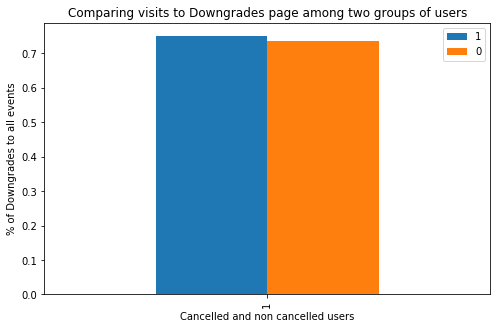

In [19]:
#Visualization


downgrades_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('% of Downgrades to all events')
plt.xlabel('Cancelled and non cancelled users')
plt.title('Comparing visits to Downgrades page among two groups of users')
plt.show()

Cancelled users appear to have visited the downgrade page slightly more than the users who did not yet cancel

#### Dislikes

In [22]:
#Obtain a dataframe of label and how many times they appeared to thumbs down

dislikes = df.select('label','page').where(col('page')=='Thumbs Down').groupby('label').count()

dis_df = pd.DataFrame({'1':(dislikes.select('count').collect()[0][0]/all_cancelled.count())*100,
                     '0':(dislikes.select('count').collect()[1][0]/stayed.count())*100}, index = [1])

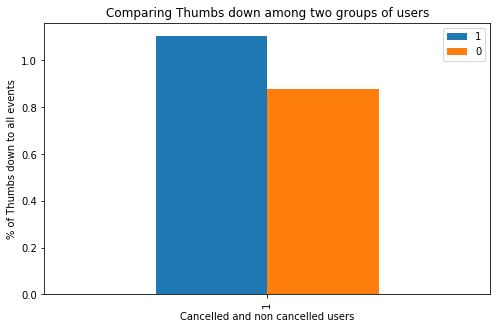

In [23]:
#Visualization


dis_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('% of Thumbs down to all events')
plt.xlabel('Cancelled and non cancelled users')
plt.title('Comparing Thumbs down among two groups of users')
plt.show()

Cancelled users appeared to press thumbs down on songs more than the users who havent cancelled

#### Liked Videos

In [24]:
#Obtain a dataframe of label and how many times they pressed thumbs up  on songs

likes = df.select('label','page').where(col('page')=='Thumbs Up').groupby('label').count()

#Percentage of thumbs down events compared to all events by each group
likes_df = pd.DataFrame({'1':(likes.select('count').collect()[0][0]/all_cancelled.count())*100,
                     '0':(likes.select('count').collect()[1][0]/stayed.count())*100}, index = [1])

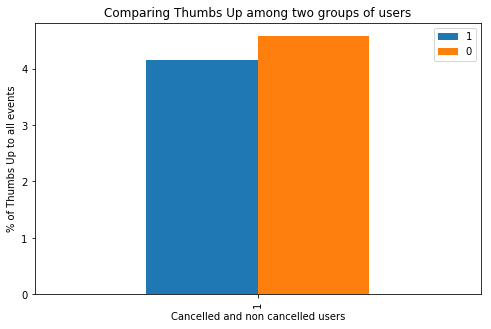

In [25]:
#Visualization


likes_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('% of Thumbs Up to all events')
plt.xlabel('Cancelled and non cancelled users')
plt.title('Comparing Thumbs Up among two groups of users')
plt.show()

Users who have not cancelled their subscriptions appear to have liked (thumbs up) to more songs

#### Adding to playlist

In [26]:
#Obtain a dataframe of label and how many times they added to their playlist

added = df.select('label','page').where(col('page')=='Add to Playlist').groupby('label').count()

#Percentage of thumbs down events compared to all events by each group
added_df = pd.DataFrame({'1':(likes.select('count').collect()[0][0]/all_cancelled.count())*100,
                     '0':(likes.select('count').collect()[1][0]/stayed.count())*100}, index = [1])

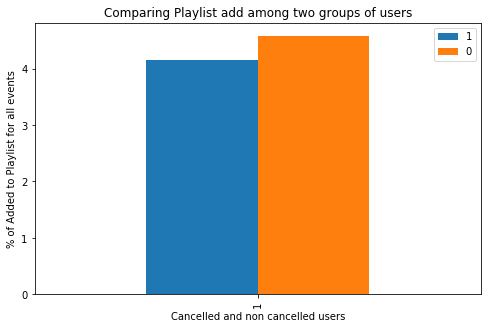

In [126]:
#Visualization


added_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('% of Added to Playlist for all events')
plt.xlabel('Cancelled and non cancelled users')
plt.title('Comparing Playlist add among two groups of users')
plt.show()

Again users who stayed seem to have added to their playlist more often

#### Error Page

In [29]:
#Obtain a dataframe of label and how many times they ended in Error page

error = df.select('label','page').where(col('page')=='Error').groupby('label').count()

#Percentage of thumbs down events compared to all events by each group
error_df = pd.DataFrame({'1':(likes.select('count').collect()[0][0]/all_cancelled.count())*100,
                     '0':(likes.select('count').collect()[1][0]/stayed.count())*100}, index = [1])

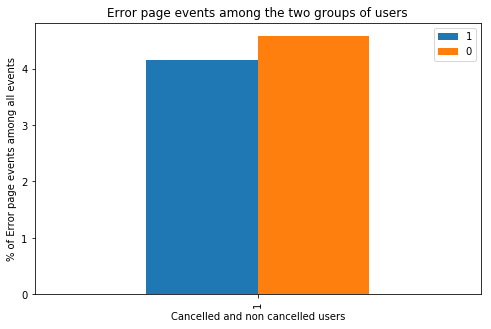

In [31]:
#Visualization


error_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('% of Error page events among all events')
plt.xlabel('Cancelled and non cancelled users')
plt.title('Error page events among the two groups of users')
plt.show()

Looks like the users who have not cancelled have more % times landed to error page more than cancelled users. So it is unlikely  a factor to make users want to leave.

#### Length of time a song played

In [124]:
#Length of time music played for each group

print('Cancelled Users:', df.select('label','length').where(col('label') == 1).where(col('length').isNotNull()).count())
print('Stayed Users:', df.select('label','length').where(col('label') == 0).where(col('length').isNotNull()).count())

Cancelled Users: 36394
Stayed Users: 191714


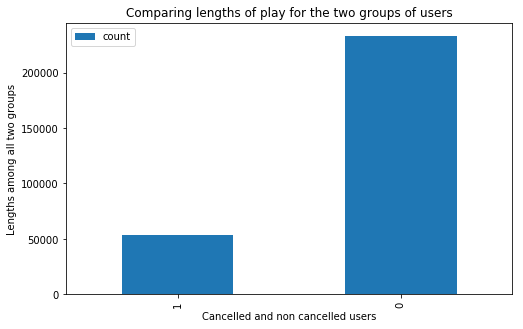

In [26]:
#Obtain a dataframe of label and how many times they ended in Error page

lengths = df.select('label','length').groupby('label').count()
lengths_df = lengths.toPandas().set_index('label')

#Visualization


lengths_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('Lengths among all two groups')
plt.xlabel('Cancelled and non cancelled users')
plt.title('Comparing lengths of play for the two groups of users')
plt.show()

In [125]:
#Number of times the 'NextSong' page was arrived at for each group

print('Cancelled Users:', df.select('label','length','page').where(col('label') == 1).where(col('page')=='NextSong').count())
print('Stayed Users:', df.select('label','length','page').where(col('label') == 0).where(col('page')=='NextSong').count())

Cancelled Users: 36394
Stayed Users: 191714


Looks like the number of times users was found at 'NextSong' page indicate valid plays where length of play is not None

Drawing from this intelligence, We can get the average length of plays for each group and compare the two as follows:

In [119]:
#Pull the average length of songs played by all users who cancelled

df.select('label','length').where(col('label') == 1).where(col('length').isNotNull()).agg(avg(col('length'))).collect()

[Row(avg(length)=248.63279564406366)]

In [120]:
#Pull the average length of songs played by all users who did not cancel

df.select('label','length').where(col('label') == 0).where(col('length').isNotNull()).agg(avg(col('length'))).collect()

[Row(avg(length)=249.20913538881427)]

It does look like the users who did not cancel have slightly higher average length of songs, even though this is very small.

#### Gender

In [31]:
#How many females in the dataset in general

(df.select('userId','gender').where(col('gender')=='F').groupby('userId').count()).toPandas().shape

(104, 2)

In [5]:
#How many Males in the dataset in general

(df.select('userId','gender').where(col('gender')=='M').groupby('userId').count()).toPandas().shape

(121, 2)

In [136]:
#Distribution of gender among the two groups - non churn users

df.select('label','gender').where(col('label')==0).groupby('gender').count().collect()

[Row(gender='F', count=135410), Row(gender='M', count=97880)]

In [12]:
#Distribution of gender among the two groups - churn users

df.select('label','gender').where(col('label')==1).groupby('gender').count().collect()

[Row(gender='F', count=19168),
 Row(gender=None, count=8346),
 Row(gender='M', count=25696)]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


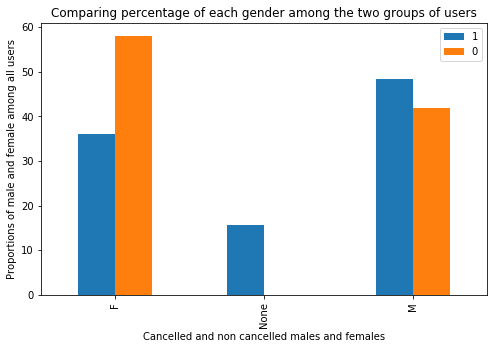

In [23]:
#Obtain a dataframe of label and gender for comprism of gender among two groups


authen1 = df.select('label','gender').where(col('label')=='1').groupby('gender').count().toPandas()
authen0 = df.select('label','gender').where(col('label')=='0').groupby('gender').count().toPandas()

#Rename columns and set level column to index
authen0_df = authen0.rename(columns={'count':'0'}).set_index('gender')
authen1_df = authen1.rename(columns = {'count':'1'}).set_index('gender')

#Concatenate the two dataframes
auth_df = pd.concat([authen1_df, authen0_df], axis = 1)

sum_1 = np.sum(auth_df['1'])

#Convert to percenttage proportions
get_percent1 = lambda x: (x/sum_1)*100
get_percent0 = lambda x: (x/stayed.count())*100


#Apply the functions to the respective columns
auth_df['1'] = auth_df['1'].apply(get_percent1)
auth_df['0'] = auth_df['0'].apply(get_percent0)


#Visualization


auth_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('Proportions of male and female among all users')
plt.xlabel('Cancelled and non cancelled males and females')
plt.title('Comparing percentage of each gender among the two groups of users')
plt.show()

Males are more likely to cancel than females. Also the invalid users ('') appear to have been cancelled users

In [22]:
#Percentage proportions of males and females

auth_df.head()

,1,0
F,36.023304,58.043637
NaN,15.685022,NaN
M,48.291674,41.956363


#### Authentication

In [138]:
df.select('label','auth').where(col('label')==1).groupby('auth').count().collect()

[Row(auth='Logged Out', count=8249),
 Row(auth='Cancelled', count=52),
 Row(auth='Guest', count=97),
 Row(auth='Logged In', count=44812)]

In [139]:
df.select('label','auth').where(col('label')==0).groupby('auth').count().collect()

[Row(auth='Logged In', count=233290)]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


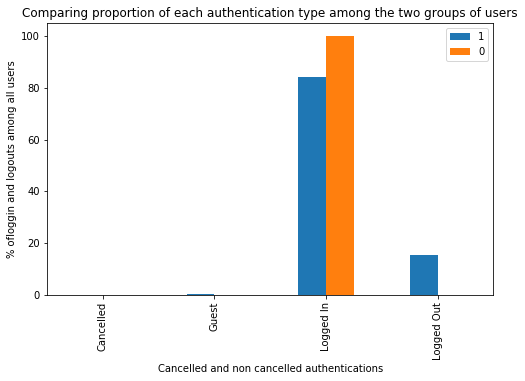

In [16]:
#Obtain a dataframe of label and gender for comprism of gender among two groups


authen1 = df.select('label','auth').where(col('label')=='1').groupby('auth').count().toPandas()
authen0 = df.select('label','auth').where(col('label')=='0').groupby('auth').count().toPandas()

#Rename columns and set level column to index
authen0_df = authen0.rename(columns={'count':'0'}).set_index('auth')
authen1_df = authen1.rename(columns = {'count':'1'}).set_index('auth')

#Concatenate the two dataframes
auth_df = pd.concat([authen1_df, authen0_df], axis = 1)

sum_1 = np.sum(auth_df['1'])

#Convert to percenttage proportions
get_percent1 = lambda x: (x/sum_1)*100
get_percent0 = lambda x: (x/stayed.count())*100


#Apply the functions to the respective columns
auth_df['1'] = auth_df['1'].apply(get_percent1)
auth_df['0'] = auth_df['0'].apply(get_percent0)


#Visualization


auth_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('% ofloggin and logouts among all users')
plt.xlabel('Cancelled and non cancelled authentications')
plt.title('Comparing proportion of each authentication type among the two groups of users')
plt.show()

##### Users who keep logging out and logging back in are more likely to cancel

#### Levels: Free or Paid

In [73]:
#Obtain a dataframe of label and levels for comprism


authen1 = df.select('label','level').where(col('label')=='1').groupby('level').count().toPandas()
authen0 = df.select('label','level').where(col('label')=='0').groupby('level').count().toPandas()

#Rename columns and set level column to index
authen0_df = authen0.rename(columns={'count':'0'}).set_index('level')
authen1_df = authen1.rename(columns = {'count':'1'}).set_index('level')

#Concatenate the two dataframes
auth_df = pd.concat([authen1_df, authen0_df], axis = 1)

sum_1 = np.sum(auth_df['1'])

#Convert to percenttages
get_percent1 = lambda x: (x/sum_1)*100
get_percent0 = lambda x: (x/stayed.count())*100


#Apply the functions to the respective columns
auth_df['1'] = auth_df['1'].apply(get_percent1)
auth_df['0'] = auth_df['0'].apply(get_percent0)


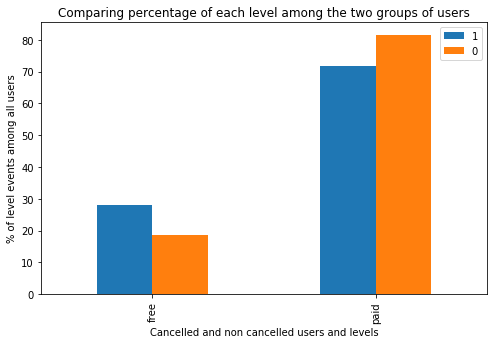

In [74]:
#Visualization


auth_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('% of level events among all users')
plt.xlabel('Cancelled and non cancelled users and levels')
plt.title('Comparing percentage of each level among the two groups of users')
plt.show()

Cancelled users appear to have streamed sparkify songs more on free level

#### Method - PUT or GET

In [79]:
df.select('label','method').where(col('label')==1).groupby('method').count().collect()

[Row(method='PUT', count=44373), Row(method='GET', count=8837)]

In [80]:
df.select('label','method').where(col('label')==0).groupby('method').count().collect()

[Row(method='PUT', count=216691), Row(method='GET', count=16599)]

In [54]:
#Obtain a dataframe of label and methods for comprism


meth1 = df.select('label','method').where(col('label')==1).groupby('method').count().toPandas()
meth0 = df.select('label','method').where(col('label')==0).groupby('method').count().toPandas()

#Rename columns and set level column to index
meth0_df = meth0.rename(columns={'count':'0'}).set_index('method')
meth1_df = meth1.rename(columns = {'count':'1'}).set_index('method')

#Concatenate the two dataframes
meth_df = pd.concat([meth1_df, meth0_df], axis = 1)

sum_1 = np.sum(meth_df['1'])

#Convert to percenttages
get_percent1 = lambda x: (x/sum_1)*100
get_percent0 = lambda x: (x/stayed.count())*100


#Apply the functions to the respective columns
meth_df['1'] = meth_df['1'].apply(get_percent1)
meth_df['0'] = meth_df['0'].apply(get_percent0)

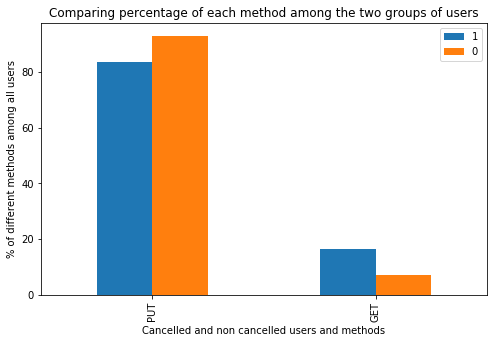

In [55]:
#Visualization


meth_df.plot(kind = 'bar', figsize = (8,5))
plt.ylabel('% of different methods among all users')
plt.xlabel('Cancelled and non cancelled users and methods')
plt.title('Comparing percentage of each method among the two groups of users')
plt.show()

Cancelled users appear to use more of 'GET' Method while non-cancelled users use more 'PUT' method

## 3. DATA PROPROCESSING AND FEATURE ENGINEERING

### Getting the features we need to perform modelling

In [100]:
features_list = ['likes', 'dislikes', 'friend_adds', 'playlist_adds', 'downgraded', 'upgraded', 'NumSongs', 'length'\
                ,'gender', 'method', 'status', 'level']#list of possibl features

**Some of the columns have sub-features which are not specific to users and so a given user may have more than one of such 
feature. Because, of this, I will engineer them as aggregates of either count, sum, or average depending on which makes more
sense. On the otherhand, some columns are pure categorical columns eg. GENDER and will not make sense to  agrregate them in any way. For these, I will simply encode them. Other columns will have certain variables that I can engineer using agrregate sums for each user eg. length of music. Further features will be engineered using insights from my exploratory analysis while avoiding duplicity of features or having two features that explain similar events.**

1. **Length:** Aggregate length by total length per user. Knowing that from exploratory analysis, the users who did not cancel have slightly higher average length of songs. 


2. **Likes:** Aggregate likes by total count of thumbs-up per user given that users who did not cancel have a higher tendency to thumbs-up on songs, compared to users who later cancelled.


3. **Dislikes:** Aggregate dislikes by total count of page -thumbs_down per user given that users who did not cancel have a lower tendency to thumbs-down on songs, compared to users who later cancelled.


4. **Added_friends:** Aggregate added_friends by total count of page -added_friends per user given that users who did not cancel have a higher tendency to add_friends (measured by percentage ratio of _add friends_ page to all other pages), compared to users who later cancelled.


5. **Playlist_adds:** Aggregate playlist_adds by total count of page -add to playlist per user given that users who did not cancel have a higher percentage ratio of add_playlist  compared to users who later cancelled.


6. **Downgraded:** Aggregate downgraded by total count of page -downgraded per user knowing that users who did not cancel have a lower percentage ratio of a downgradeed  compared to users who later cancelled.


7. **Upgraded:** Aggregate upgraded by total count of page -upgraded per user knowing that users who did not cancel have a higherr percentage ratio of a upgradeed  compared to users who later cancelled.


8. **NumSongs:** Aggregate Songs by total count of songs per user knowing that users who did not cancel have a higher average number of a songs  compared to users who later cancelled. 'NextSong' page is akin to valid plays where length of play is not None, this should be synonymous to count of songs and will not add extra benefit to the model  if included.


9. **Method_Put:** Aggregate PUT method by the number of times each user used the PUT method. This because a user may have used more than one method, hence, setting it of as simply categorical will not clearly reflect the effect of this feature


10. **Method_Get:** Aggregate GET method by the number of times each user used the GET method. Same logic as the PUT method


11. **Gender:** Group the users according to gender, as no user appeared to have more than one gender. Thus, gender is a purely categorical feature.


12. **Status_307:** Aggregate status by the number of times each user used the status of 307. This is since certain user used more that one type of staus


13. **Status_200:** Aggregate status by the number of times each user used the status of 200. 


14. **Status_404:** Aggregate status by the number of times each user used the status of 404 to stream a song.


15. **Level_paid:** Aggregate level by the number of times each user used the Paid level to stream a song.


16. **Level_free:** Aggregate status by the number of times each user used the Free level to stream a song.



##### Create/engineer all necessary features and combne into a list

In [31]:
def engineer_features(df):
    '''
    Script to create all the needed feature for the model-classisfication problem of user churn for
    sparkify. creates and combine all the features into a list of dataframes

    
    Args:
        df: The dataframe of the events recorded for users on the streaming platform
    Returns:
        returns a list of dataframes of the features needed for modelling.
    '''
    dat_f = []#define list to combine all features
    #Aggregate length by total sum per user
    length = (df.select('userId', 'length').groupby('userId').agg({'length':'sum'})).select('userId', col('sum(length)')\
                                                                                            .alias('count'))
    dat_f.append(('length', length))
    
    #Aggregate dislikes by total count per user
    dislikes = df.select('userId','page').where(col('page')=='Thumbs Down').groupby('userId').count()
    dat_f.append(('dislikes', dislikes))
    
    likes = df.select('userId','page').where(col('page')=='Thumbs Up').groupby('userId').count()
    dat_f.append(('likes', likes))
    
    #Aggregate added friends by total count per user
    friend_adds = df.select('userId','page').where(col('page')=='Add Friend').groupby('userId').count()
    dat_f.append(('friend_adds', friend_adds))
    
    #Aggregate playlist_adds by total count per user
    playlist_adds = df.select('userId','page').where(col('page')=='Add to Playlist').groupby('userId').count()
    dat_f.append(('playlist_adds', playlist_adds))
    
    #Aggregate downgrades by total count per user
    downgraded = df.select('userId','page').where(col('page')=='Downgrade').groupby('userId').count()
    dat_f.append(('downgraded', downgraded))
    
    #Aggregate upgraded by total count per user
    upgraded = df.select('userId','page').where(col('page')=='Upgrade').groupby('userId').count()
    dat_f.append(('upgraded', upgraded))
    
    #Aggregate users by number of features
    NumSongs = (df.select('userId', 'song').groupby('userId').agg({'song':'count'})).select('userId', col('count(song)').alias('count'))
    dat_f.append(('NumSongs', NumSongs))
    
    #Aggregate method_put by total count per user
    method_put = df.select('method', 'userid').where(col('method') == 'PUT').groupby('userId').count()
    dat_f.append(('method_put', method_put))
    
    #Aggregate method_get by total count per user
    method_get = df.select('method', 'userid').where(col('method') == 'GET').groupby('userId').count()
    dat_f.append(('method_get', method_get))
    
    #Group gender per user
    gender = (df.select('userId','gender').groupby('userId','gender').count()).select(\
                                                                                  'userId', col('gender').alias('count'))
    dat_f.append(('gender', gender))
    
    #Aggregae status_307 per user
    status_307 = df.select('status', 'userid').where(col('status') == 307).groupby('userId').count()
    dat_f.append(('status_307', status_307))
    
    #Aggregae status_404 per user
    status_404 = df.select('status', 'userid').where(col('status') == 404).groupby('userId').count()
    dat_f.append(('status_404', status_404))
    
    #Aggregae status_200 per user
    status_200 = df.select('status', 'userid').where(col('status') == 200).groupby('userId').count()
    dat_f.append(('status_200', status_200))
    
    #Aggregate for each user, how many times it streamed sparkify songs using level -FREE
    level_free = df.select('level', 'userid').where(col('level') == 'free').groupby('userId').count()
    dat_f.append(('level_free', level_free))
    
    #Aggregate for each user, how many times it streamed sparkify songs using level -PAID
    level_paid = df.select('level', 'userid').where(col('level') == 'paid').groupby('userId').count()
    dat_f.append(('level_paid', level_paid))
    
    #Group gender per user
    #gender = (df.select('userId','gender').groupby('userId','gender').count()).select('userId', col('gender').alias('count'))
    
    return dat_f

In [32]:
def Concat_DataFrames(dat_f, how = 'outer'):
    '''
    Concatenates all feature dataframes into one dataframe where each column is a feature, an only have one userId column
    Assumes all new dataframes to have a 'userId' column, and a 'count' column
    
    Args:
        data_f: list_dataframes - The list of dataframes to concatenate
        how - 'outer' the type of join to use
    Returns:
        returns a dataframe of the features needed.
    '''
    
    #Combine all the features into a given dataframe that will be the features dataframe.
    
    #Get the first dataframe and rename count to its actual name
    feature_df0 = dat_f[0][1].withColumnRenamed('count', dat_f[0][0])
    feature_df0 = feature_df0.withColumnRenamed('userId', 'userId1')
    
    #for the remaining dataframe, join using 'outer' to retain the number of users in the first dataframe
    for name, dataframe in dat_f[1:]:
        
        #rename column 'count' to actual name
        dataframe = dataframe.withColumnRenamed('count', name)#rename column 'count' to actual name
        
        #join two dataframes into one and delete the new userId
        feature_df0 = feature_df0.join(dataframe, feature_df0.userId1 == dataframe.userId, how)\
        .drop(dataframe.userId)#join two dataframes into one and delete the new userId
    
    return feature_df0

#Use the above function to create a features_dataframe
feature_df = Concat_DataFrames(engineer_features(df), how = 'outer')#Create the features dataframe

In [11]:
#Feature feature_df.cache()

DataFrame[userId1: string, length: double, dislikes: bigint, likes: bigint, friend_adds: bigint, playlist_adds: bigint, downgraded: bigint, upgraded: bigint, NumSongs: bigint, method_put: bigint, method_get: bigint, gender: string, status_307: bigint, status_404: bigint, status_200: bigint, level_free: bigint, level_paid: bigint]

#### Report descriptive statistics of each feature to be used in modelling

In [40]:
#Features engineered
feats = engineer_features(df)

In [43]:
#Get and report the descriptive statistics of each feature

#for name, dataframe in feats:
#    print(name)
#    dataframe.describe().show()
    

In [36]:
#First batch

feature_df.select('userId1', 'length', 'dislikes', 'likes', 'friend_adds', 'playlist_adds').describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+
|summary|           userId1|            length|          dislikes|            likes|       friend_adds|    playlist_adds|
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+
|  count|               226|               225|               203|              220|               206|              215|
|   mean|65391.013333333336|252558.32065155543|12.541871921182265|            57.05|20.762135922330096|30.35348837209302|
| stddev|105396.47791907164| 275396.4038847635|13.198108566983787|65.67028650524044|20.646779074405007| 32.8520568555997|
|    min|                  |         691.66884|                 1|                1|                 1|                1|
|    max|                99|1991154.9155799907|                75|              437|               143|              240|
+-------+---------------

In [37]:
#Second batch

feature_df.select('downgraded', 'upgraded', 'NumSongs', 'gender', 'method_put', 'method_get').describe().show()

+-------+------------------+------------------+------------------+------+------------------+------------------+
|summary|        downgraded|          upgraded|          NumSongs|gender|        method_put|        method_get|
+-------+------------------+------------------+------------------+------+------------------+------------------+
|  count|               154|               168|               226|   225|               226|               225|
|   mean|13.344155844155845|2.9702380952380953|1009.3274336283185|  null|1155.1504424778761|113.04888888888888|
| stddev| 12.04315761589023|2.5557861915159594|1104.5631691003189|  null|1251.3647818547836|345.16616380363917|
|    min|                 1|                 1|                 0|     F|                 3|                 2|
|    max|                73|                15|              8002|     M|              8958|              5100|
+-------+------------------+------------------+------------------+------+------------------+------------

In [38]:
#Third batch

feature_df.select('status_307', 'status_404', 'status_200', 'level_free', 'level_paid').describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|        status_307|        status_404|        status_200|        level_free|        level_paid|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               224|               118|               226|               196|               166|
|   mean|117.99107142857143|2.1864406779661016|1149.6106194690265|297.64285714285717|1374.4698795180723|
| stddev|237.57047556804517|1.4319262774221952|  1244.97869992402|348.09607427128066| 1309.055160884664|
|    min|                 1|                 1|                 6|                 4|                 1|
|    max|              3246|                 7|              8909|              2617|              7779|
+-------+------------------+------------------+------------------+------------------+------------------+



### Null elements

In [13]:
#Since some users will not have values for certain features, they were captured as NULL. In actual sense, these null elements
# are zero values, considering aggregates were used. Hence, I will replace these null elements with zeros for all columns.

feature_df = feature_df.fillna(0)

In [42]:
feature_df.show(4)

+-------+------------------+-----+--------+-----------+-------------+----------+--------+--------+------+----------+----------+----------+----------+----------+----------+----------+
|userId1|            length|likes|dislikes|friend_adds|playlist_adds|downgraded|upgraded|NumSongs|gender|method_put|method_get|status_307|status_404|status_200|level_free|level_paid|
+-------+------------------+-----+--------+-----------+-------------+----------+--------+--------+------+----------+----------+----------+----------+----------+----------+----------+
| 100010| 66940.89735000003|   17|       5|          4|            7|         0|       2|     275|     F|       313|        68|        31|         0|       350|       381|         0|
| 200002| 94008.87593999993|   21|       6|          4|            8|         5|       2|     387|     M|       432|        42|        37|         0|       437|       120|       354|
|    125|2089.1131000000005|    0|       0|          0|            0|         0|     

In [13]:
feature_df.hint('skew').count()

226

### Categorical columns:

In [83]:
feature_df.persist()

DataFrame[userId1: string, length: double, likes: bigint, dislikes: bigint, friend_adds: bigint, playlist_adds: bigint, downgraded: bigint, upgraded: bigint, NumSongs: bigint, gender: string, method_put: bigint, method_get: bigint, status_307: bigint, status_404: bigint, status_200: bigint, level_free: bigint, level_paid: bigint]

The only truly categorical feature at this point is the gender, and this can be simply taken care of using string indexing.
Other feature scaling and selection will include:
    
    a. Vector assembling of all features into one vector
    b. Feature scaling using Normalizer, the chosen scaler.
    
For all these, I will pipeline them into one series on steps and execute them, alongside the modeling. 

### Distribtion of features/Choosing Scaler

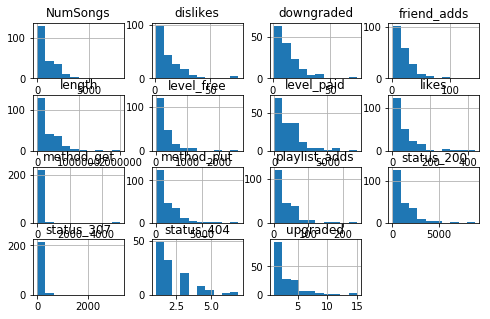

In [39]:
#Data Visualizations
#using histograms to find distributions of each field

feature_df1 = feature_df.toPandas().set_index('userId1')
feature_df1.iloc[:,:].hist(figsize = (8,5))
pyplot.show()

The distribution of all the features is a deviation from normal, and can best be described as log-normal. In addition, there
appear to be some outliers in the features. Hence, a normalizer will be chosen over a standard scaler to effectively scale the
features.

#### Combine the feature and label dataframe into df_ready and remove the user ''

In [14]:
#Create the label column for all users

label = (df.select('label', 'userid').groupby('userId','label').count()).select(\
                                                                                  'userId', 'label')

In [15]:
#Combine 

df_ready = feature_df.join(label, feature_df.userId1 == label.userId, how = 'outer').drop(label.userId)#join two dataframes
df_ready = df_ready.select('*').where(col('userId1') != '')#Remove the invalid user
df_ready = df_ready.withColumnRenamed('userId1', 'Id')#rename the userId1 to Id

In [14]:
#df_ready.count()

In [34]:
df_ready.persist()

Row(Id='100010', length=66940.89735000003, dislikes=5, likes=17, friend_adds=4, playlist_adds=7, downgraded=0, upgraded=2, NumSongs=275, method_put=313, method_get=68, gender='F', status_307=31, status_404=0, status_200=350, level_free=381, level_paid=0, label=0)

#### Pipeline:

Build a pipeline that will apply all the feature transformation steps to gether with a machine learning model

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
# First I will define a baseline model - using logistic regression.
#Then, I will further use grid search to tune the best performing parameters for various models. Further I will apply the
#best perfroming on the validation set.

### Split into Train and Test datasets:
Split datasets into train and test sets in the ratio of (0.75, 0.25)

In [18]:
train_set, test_set = df_ready.randomSplit([0.75,0.25], seed = 5)

In [34]:
train_set.persist()

DataFrame[Id: string, length: double, likes: bigint, dislikes: bigint, friend_adds: bigint, playlist_adds: bigint, downgraded: bigint, upgraded: bigint, NumSongs: bigint, gender: string, method_put: bigint, method_get: bigint, status_307: bigint, status_404: bigint, status_200: bigint, level_free: bigint, level_paid: bigint, label: int]

### Baseline Model -  LogisticRegression

In [22]:
#LogisticRegression

#Apply string Indexer on the genger column
Indexer1 = StringIndexer(inputCol = 'gender', outputCol = 'gender_indexed')
#Assemble features into one 
assembler = VectorAssembler(inputCols=['length', 'likes', 'dislikes', 'friend_adds', 'playlist_adds', 'downgraded', \
                                           'upgraded','NumSongs', 'method_put', 'method_get', 'status_307', 'status_404',\
                                           'status_200', 'level_free', 'level_paid', 'gender_indexed'], outputCol="features")
    
#use Normalizer to normalize features
NScaler = Normalizer(inputCol = 'features', outputCol = 'scaledFeatures')

#modeler = LogisticRegression(fitIntercept = False, family="multinomial", featuresCol = 'scaledFeatures')odeler = model

#1

modeler = LogisticRegression(fitIntercept = False, family="multinomial", featuresCol = 'scaledFeatures', maxIter = 10,\
                             regParam=0.3, elasticNetParam=0.8)

#2

#modeler = LogisticRegression(fitIntercept = False, family="multinomial", featuresCol = 'scaledFeatures', maxIter = 10,\
#                             regParam=0.3, elasticNetParam=0.5)

#Design a pipeline to run through all the modeling process
pipeline = Pipeline(stages=[Indexer1, assembler, NScaler, modeler])


In [23]:
best_model = pipeline.fit(train_set)

In [24]:
best_model.save("LRmodel_1")

In [5]:
path = "LRmodel_1"
LR_mod = PipelineModel.load(path)

In [17]:
def evaluate_model(built_model, model_name, testing_set, evaluator = MulticlassClassificationEvaluator()):
    
    '''
    Function to evaluate the performance of a model. it returns the important score metrics 
    Args:
        build_model - the model already trained whose performance is to be evaluated.
        testing_set - the dataset which the model is to be tested on, could be train, test, or validation.
        evaluator - the type of evaluator, default is BinaryClassificationEvaluator.
    Returns:
        Print important metrics including Accuracy and Recall
    '''
    #Number of possible predictions
    gh = testing_set.count()
    
    #make predictions
    pred_results = built_model.transform(testing_set).select("features", "label", "prediction")
    
    #define an object of the evaluator
    #evaluator = BinaryClassificationEvaluator(metric = a)
    evaluator = evaluator
    
    #compute all the important metrics
    TPTN = pred_results.filter(pred_results.label == pred_results.prediction).count()#True Positive  and True Negative
    print(f"The Accuracy of {model_name}  is: {TPTN/gh}")
    
    #True Positives
    TP = pred_results.filter(pred_results.label == pred_results.prediction).where(col('prediction') == 1).count()
    
    #True Negatives
    FN = pred_results.filter(pred_results.label != pred_results.prediction).where(col('prediction') == 0).count()
    
    #Recall
    Recall = TP/(TP+FN)
    
    print(f"The Recall of {model_name}  is: {Recall}")

In [19]:
#Use model to make predictions

pred_results = LR_mod.transform(test_set)\
    .select("id", "label", "prediction")

In [26]:
#Find out if there is an accurate prediction of a churn user

pred_results.select('*').where(col('prediction') == 1).show()

+--------+-----+----------+
|features|label|prediction|
+--------+-----+----------+
+--------+-----+----------+



In [20]:
#Define the evaluator object

evaluator = MulticlassClassificationEvaluator()

In [21]:
TPTN = pred_results.filter(pred_results.label == pred_results.prediction).count()#True Positive  and True Negative

In [22]:
TP = pred_results.filter(pred_results.label == pred_results.prediction).where(col('prediction') == 1).count()#TruePositivesOnly

In [23]:
FN = pred_results.filter(pred_results.label != pred_results.prediction).where(col('prediction') == 0).count()#FalseNegatives

In [24]:
#Recall

Recall = TP/(TP+FN)
Recall

0.0

In [25]:
#Total predictables

gh = test_set.count()#Total

In [28]:
#F1 score

F1 = evaluator.evaluate(pred_results)
F1

0.726808176100629

In [29]:
#Accuracy

Accuracy = TPTN/gh
Accuracy

0.8113207547169812

### RandomForest - 
Cross Validation and Grid search

In [17]:
#Apply string Indexer on the genger column
Indexer1 = StringIndexer(inputCol = 'gender', outputCol = 'gender_indexed')

#Assemble features into one 
assembler = VectorAssembler(inputCols=['length', 'likes', 'dislikes', 'friend_adds', 'playlist_adds', 'downgraded', \
                                           'upgraded','NumSongs', 'method_put', 'method_get', 'status_307', 'status_404',\
                                           'status_200', 'level_free', 'level_paid', 'gender_indexed'], outputCol="features")
    
#Normalizer not needed in RandomForests
#NScaler = Normalizer(inputCol = 'features', outputCol = 'scaledFeatures')

#modeler = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees = 8, maxDepth = 4)
modeler = RandomForestClassifier()#RandomForest Classifier

#Design a pipeline to run through all the modeling process
pipeline = Pipeline(stages=[Indexer1, assembler, modeler])

paramGrid = []

#RandomForest
paramGrid.append((ParamGridBuilder() \
                  .addGrid(modeler.numTrees, [5, 8, 10, 15])\
                  .addGrid(modeler.maxDepth, [4,8]) \
                  .build()))

In [25]:
#Apply cross validation to search through the grid parmeters for the best performing 

cross_val = CrossValidator(estimator = pipeline,
                           estimatorParamMaps = paramGrid[0],
                           evaluator = MulticlassClassificationEvaluator(),
                           numFolds = 3)

In [27]:
#Set threshold parameters to prevent crash of jobs

spark.conf.set("spark.sql.broadcastTimeout", 50000)
spark.conf.set("spark.driver.memory", "10g")

In [31]:
#Fit model to test set
best_model2 = cross_val.fit(train_set)

In [35]:
best_model2.bestModel.save('best_rF_model1')#Save model 

In [33]:
path = "best_rF_model1"

In [34]:
RF_mod = PipelineModel.load(path)#Load model

#### Obtain best perfroming parameters from parameters grid

In [36]:
java_model = RF_mod.stages[-1]._java_obj
#best Model's number of trees

java_model.getNumTrees()

8

In [76]:
#Best model's max depth

java_model.getMaxDepth()

4

In [ ]:
#Use  F1-score so you can determine how well the model can distinguish between the two classes in its predictions. If it predicts 
# a 1 as 1 and a 0 as 0. Ie how much the model can get the different classes right

In [21]:
#make predictions

pred_results = RF_mod.transform(test_set)\
    .select('id', "label", "prediction")

In [24]:
#Define an evaluator object

evaluator = MulticlassClassificationEvaluator()

In [25]:
TPTN = pred_results.filter(pred_results.label == pred_results.prediction).count()#True Positive  and True Negative

In [28]:
TP = pred_results.filter(pred_results.label == pred_results.prediction).where(col('prediction') == 1).count() #TruePositives

In [29]:
FN = pred_results.filter(pred_results.label != pred_results.prediction).where(col('prediction') == 0).count()#FalseNegatives

In [30]:
gh = test_set.count()#Total

In [31]:
#Recall

Recall = TP/(TP+FN)

In [32]:
Recall

0.1

In [38]:
#F1 score

F1 = evaluator.evaluate(pred_results)
F1

0.732450486347123

In [37]:
#Accuracy

Accuracy = TPTN/gh
Accuracy

0.7735849056603774

In [35]:
pred_results.filter(pred_results.prediction == 1).select('id', 'label', 'prediction').show()

+------+-----+----------+
|    id|label|prediction|
+------+-----+----------+
|   139|    0|       1.0|
|100004|    0|       1.0|
|300014|    0|       1.0|
|100012|    1|       1.0|
+------+-----+----------+



### Decision Trees
Cross validation and grid search

In [21]:
#Encoder the gender column
Indexer1 = StringIndexer(inputCol = 'gender', outputCol = 'gender_indexed')

#Assemble features into one
assembler = VectorAssembler(inputCols=['length', 'likes', 'dislikes', 'friend_adds', 'playlist_adds', 'downgraded', \
                                           'upgraded','NumSongs', 'method_put', 'method_get', 'status_307', 'status_404',\
                                           'status_200', 'level_free', 'level_paid', 'gender_indexed'], outputCol="features")

#certain parameters as numClasses is equal to 2, 
modeler = DecisionTreeClassifier(labelCol="label", featuresCol="features")#DecisionTree Classifier

pipeline = Pipeline(stages=[Indexer1, assembler, modeler])

paramGrid = []

#DecisionTree
paramGrid.append((ParamGridBuilder() \
                  .addGrid(modeler.maxDepth, [1,2,3]) \
                  .addGrid(modeler.maxBins, [2,10,32]) \
                  .build()))

In [21]:
spark.conf.set("spark.sql.broadcastTimeout", 50000)
spark.conf.set("spark.driver.memory", "10g")

In [23]:
#Apply cross validation to search through the grid parmeters for the best performing 

cross_val = CrossValidator(estimator = pipeline,
                           estimatorParamMaps = paramGrid[0],
                           evaluator = BinaryClassificationEvaluator(),
                           numFolds = 3)

#Fit model to test set
DT_model = cross_val.fit(train_set)

# Save and load model
DT_model.bestModel.save("DTreeModel_CV")

#path = "DTreeModel_CV"
#test_mod = PipelineModel.load(pathModel)

In [28]:
#Get model's best perfroming parameters

java_model = DT_model.bestModel.stages[-1]._java_obj
#best Model's max depth choice

java_model.getMaxDepth()

3

In [29]:
#Model's best performing Max Bins

java_model.getMaxBins()

32

In [37]:
path = "DTreeModel_CV"

In [38]:
DT_mod = PipelineModel.load(path)

In [41]:
#Make predictions

pred_results = DT_mod.transform(test_set)\
    .select('id', "label", "prediction")

In [43]:
#F1-score

F1 = evaluator.evaluate(pred_results)
F1

0.7635634805446126

In [44]:
TP = pred_results.filter(pred_results.label == pred_results.prediction).where(col('prediction') == 1).count() #TruePositives

In [45]:
TPTN = pred_results.filter(pred_results.label == pred_results.prediction).count()#True Positive  and True Negative

In [46]:
FN = pred_results.filter(pred_results.label != pred_results.prediction).where(col('prediction') == 0).count()#FalseNegatives

In [47]:
#Recall

Recall = TP/(TP+FN)
Recall

0.2

In [48]:
#Accuracy

Accuracy = TPTN/gh
Accuracy

0.7924528301886793

In [96]:
#How much of the churn users predictions were accurate

pred_results.select("label", "prediction").where(col('prediction') == 1).show()

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
+-----+----------+



In [55]:
#feature_imp = RF_mod.featureImportances.values.tolist()

### OverSampling of churn Users using SMOTE

In [75]:
#adapted this SMOTESampling code online from https://github.com/Angkirat/Smote-for-Spark/blob/master/PythonCode.py

def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    '''
    Function to apply Synthetic Minority Oversampling Technique (SMOTE) using pyspark on the train set so as to increase the
    percentage of the minority class (label = 1)to equal that of the majority class (label = 0)
    Args:
        vectorized - the train set already in a vectorized format (apllied VectorAssembler)
        minorityClass - the value of the label which contitute the minority in the label column
        majorityClass - the value of the label which contitute the majority in the label column
        percentageOver - how much you want the minority increased
        percentageUnder - the current percentage value
        k = 
    Returns:
        built_model
        evautor metric for the model
    '''
    
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = int(percentageOver/100)
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    
    newData_rdd = sc.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)




Indexer1 = StringIndexer(inputCol = 'gender', outputCol = 'gender_indexed')

#Assemble features into one 
assembler = VectorAssembler(inputCols=['length', 'likes', 'dislikes', 'friend_adds', 'playlist_adds', 'downgraded', 'upgraded',\
                                       'NumSongs', 'method_put', 'method_get', 'status_307', 'status_404',\
                                       'status_200', 'level_free', 'level_paid', 'gender_indexed'], outputCol="features")

#Define a pipeine that will apply both StringIndexing and vectorAssemby and any other needed transformation before applyin
#smote

pipeline1 = Pipeline(stages = [Indexer1, assembler])

train_set1 = pipeline1.fit(train_set).transform(train_set)#transform the train set using the indexer and Assmebler
train_set2 = train_set1.select('features', 'label')#bring out only the feature and label columns

new_train = SmoteSampling(train_set2, k = 2, minorityClass = 1, majorityClass = 0)#apply Smote to the new train data

test_set1 = pipeline1.fit(test_set).transform(test_set)#transform test_set to be in the form of train set, without adding rows


In [21]:
new_train.persist()

DataFrame[features: vector, label: bigint]

### RandomForestClassifier performance testing using SMOTE train set.

In [33]:
#spark.conf.set("spark.sql.broadcastTimeout", 5000)

modeler = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees = 8, maxDepth = 4)
best_model = modeler.fit(train_set)
#best_model.save(sc, 'best_rF_model')
test_set1 = pipeline1.fit(test_set).transform(test_set)
pred_results = best_model.transform(test_set1)

In [34]:
pred_results.select("label", "prediction").where(col('prediction') == 1).show()#print number of predictions of users as churn

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
+-----+----------+



### DecisionTree performance testing using SMOTE train set.

In [76]:
Indexer1 = StringIndexer(inputCol = 'gender', outputCol = 'gender_indexed')

#Assemble features into one 
assembler = VectorAssembler(inputCols=['length', 'likes', 'dislikes', 'friend_adds', 'playlist_adds', 'downgraded', 'upgraded',\
                                       'NumSongs', 'method_put', 'method_get', 'status_307', 'status_404',\
                                       'status_200', 'level_free', 'level_paid', 'gender_indexed'], outputCol="features")
#Apply pipeline of just indexer and assembler to prpare the test set
pipeline1 = Pipeline(stages = [Indexer1, assembler])

#Transform the test set
test_set1 = pipeline1.fit(test_set).transform(test_set)

In [98]:
new_train.count()

256

In [77]:
#Define modeling technique

modeler = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins = 32, maxDepth = 3)

#Fit model to the new train set
best_model2 = modeler.fit(new_train)

pred_results1 = best_model2.transform(test_set1)#make predictions on the test_set

In [78]:
pred_results1.select("label", "prediction").where(col('prediction') == 1).show()#print number of predictions of users as churn

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
+-----+----------+



### Conclusions and Doscussion:

The project has availed the opportunity to understand the behaviour of users on Sparkify music streaming platform. Using machin
lerning models such as RandomForestClassifier and DecisionTreeClassfier, the possible departure/cancelation of users who subsc-
cribed to the platform can be predicted. The ability of the two to make predictions given the dataset used is hampered owing to
the presence of a huge imbalance in the labels of the users. The dataset has predominantly users who have not cancelled in the
ratio of 173/52. This makes prediction of possible churn harder. Nevertheless, DecsionTreeClassifier showed a better performance  with an F1-score of 0.76 against the RandomForestCalssifier with an F1-score of 0.73 and the baseline model using LogisticRegression which showed an F1-score of 0.72.

Becasue of this imbalance, an attempt to increase the number of churn users through SMOTE sampling was made, adapting a code from https://github.com/Angkirat/Smote-for-Spark/blob/master/PythonCode.py. However, this attempt did not yeild a significant outcome.

### Recommendation:

Further work should include testing other machine learning algorithms such as GradientBosstingTree and NaiveBayes. Also, 
another attempt at augmenting the dataset by weighting the labels in order to give the churn users a higher weight than the non
churn users could help mitigate the effect of the imbalance in the dataset. Finally, more features could still be engineered 
a feature selection technique to reduce the number of features to the most impactful could be explored to improve run time.

### References:

https://github.com/Angkirat/Smote-for-Spark/blob/master/PythonCode.py.
    
https://medium.com/@sajad1009/credit-card-fraud-detection-with-spark-and-python-high-accuracy-27a8ba8ed32
    
https://www.researchgate.net/post/How_to_determine_the_number_of_trees_to_be_generated_in_Random_Forest_algorithm

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.